In [1]:
import re
import os
import io
import cv2
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from rdkit import Chem

import sys
sys.path.append('../')
from util import *
# from dataloader import MoleculeDataset
from models.sasa import ResNet26, ResNet38, ResNet50, get_model_parameters
from models.axial import AxialAttention

%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

RDKit WARNING: [14:48:37] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
DATA_DIR = '/Users/prguser/big_data/bms_kaggle'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_RESIZE_DIR = os.path.join(DATA_DIR, 'train_resize')
TEST_RESIZE_DIR = os.path.join(DATA_DIR, 'test_resize')
MAX_INCHI_LENGTH = 350
with open('../data/char_dict.json', 'r') as f:
    CHAR_DICT = json.load(f)
with open('../data/ord_dict.json', 'r') as f:
    ORD_DICT = json.load(f)

In [3]:
def get_n_samples(DIR):
    n_samples = 0
    for i in os.listdir(DIR):
        if '.' == i[0]:
            pass
        else:
            for j in os.listdir(os.path.join(DIR, i)):
                if '.' == j[0]:
                    pass
                else:
                    for k in os.listdir(os.path.join(DIR, i, j)):
                        if '.' == k[0]:
                            pass
                        else:
                            n_samples += len(os.listdir(os.path.join(DIR, i, j, k)))
    return n_samples

In [4]:
n_train_samples = get_n_samples(TRAIN_DIR)
n_test_samples = get_n_samples(TEST_DIR)

In [5]:
'{} training samples, {} test samples'.format(n_train_samples, n_test_samples)

'2424186 training samples, 1616107 test samples'

Training samples are labeled with InChI strings, test samples are unlabeled.

In [6]:
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
test_labels = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
train_labels.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


In [7]:
test_labels.head()

,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


In [8]:
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')

# Exploring the Inputs

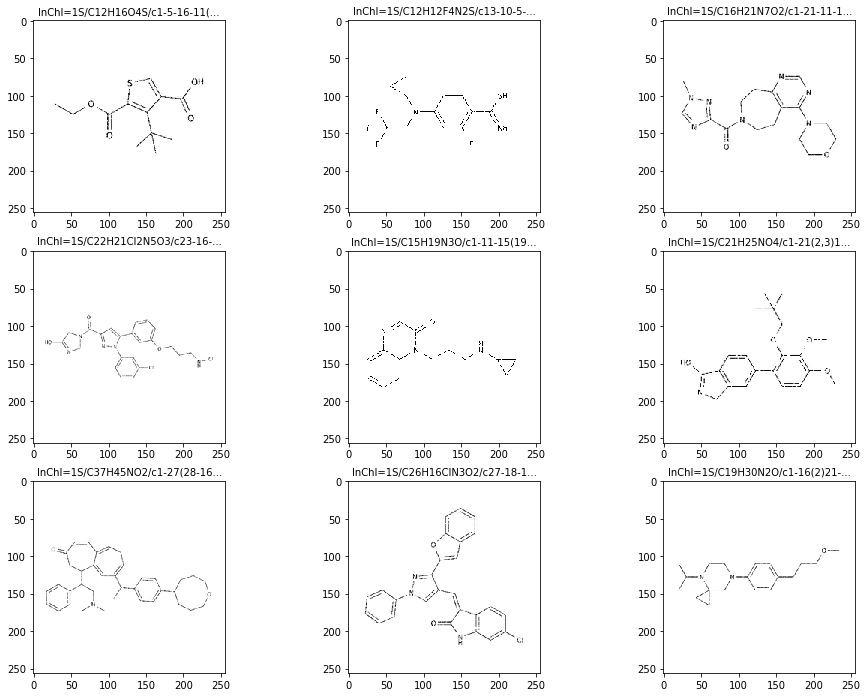

In [98]:
def get_path_from_img_id(img_id, DIR):
    img_path = os.path.join(DIR, img_id[0], img_id[1], img_id[2], '{}.png'.format(img_id))
    return img_path

def visualize_sample(train_labels):
    plt.figure(figsize=(16,12))
    sample = train_labels.sample(n=9)
    img_ids = sample.image_id.values
    labels = sample.InChI.values
    for idx, (img_id, label) in enumerate(zip(img_ids, labels)):
        plt.subplot(3, 3, idx+1)
        img_path = get_path_from_img_id(img_id, TRAIN_RESIZE_DIR)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{label[:30]}...", fontsize=10)
#         plt.title("{} height, {} width".format(img.shape[0], img.shape[1]))
    plt.show()

def visualize_img_id(img_id):
    plt.figure(figsize=(16,12))
    img_path = get_path_from_img_id(img_id, load_dir='train_resize')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

visualize_sample(train_labels)

Obviously, images are very noisy. I think it'll be worth supplementing with less noisy labeled molecular structures (pretty sure we can easily get this data from PubChem). Additionally, we might be able to "fill in" very grainy images based on image correction machine learning models that are used for de-noising photographs, renders, etc. 

One way might be to find the exact same molecule on PubChem and train a model to first fix the noisy image.

Finally, image sizes will need to be normalized but it is not clear what the best method for doing so will be. My intuition says that we should use a large padded input box that allows us to keep all features the same size (i.e. a single aromatic ring should occupy the same number of pixels regardless of the total size of the molecule).

### Denoise

In [16]:
def denoise_img(img_path, dot_size=2):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, BW = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    nlabels, labels, stats, _ = cv2.connectedComponentsWithStats(BW, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:,-1]
    img2 = np.zeros((labels.shape), np.uint8)
    for i in range(0, nlabels-1):
        if sizes[i] >= dot_size:
            img2[labels == i+1] = 255
    img = cv2.bitwise_not(img2)
    return img

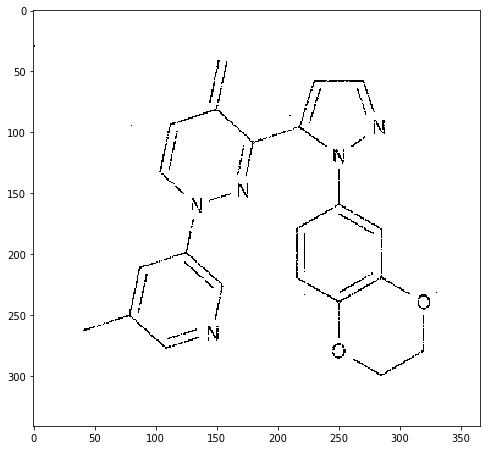

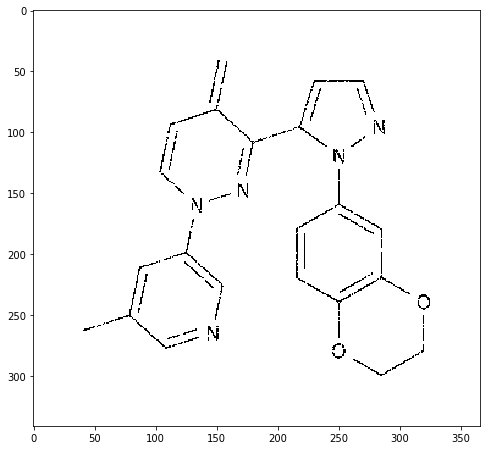

In [29]:
img_path = get_path_from_img_id(train_labels.sample(n=1).image_id.values[0], TRAIN_DIR)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.show()
img = denoise_img(img_path)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.show()

In [103]:
from skimage import morphology

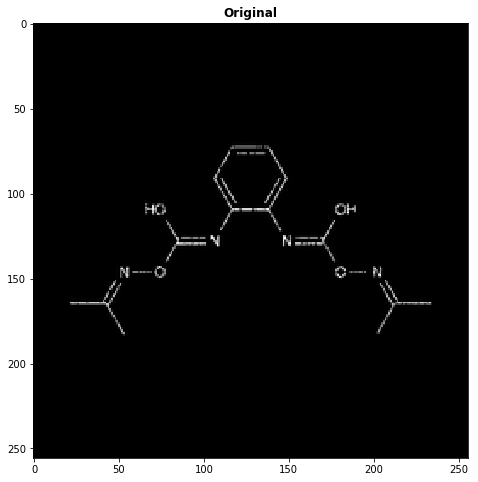

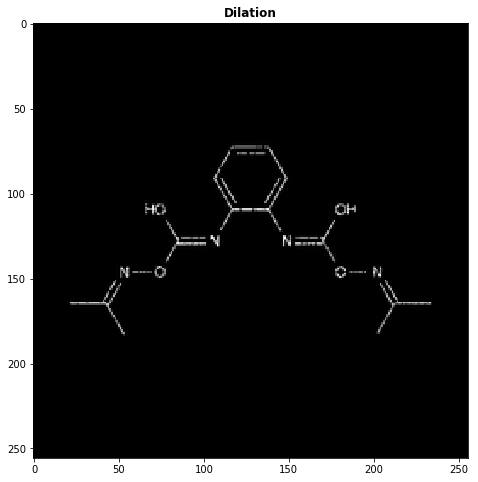

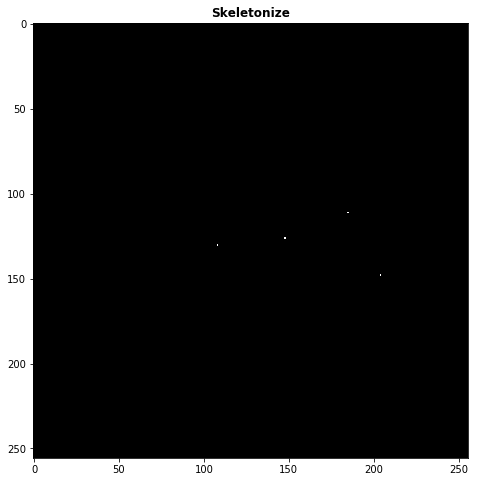

In [104]:
img_path = get_path_from_img_id(train_labels.sample(n=1).image_id.values[0], TRAIN_RESIZE_DIR)
img = (255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)) / 255
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('Original', fontweight='bold')
plt.show()
img = morphology.dilation(img, selem=morphology.square(1))
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('Dilation', fontweight='bold')
plt.show()
# img = morphology.erosion(img)
# plt.figure(figsize=(8,8))
# plt.imshow(img, cmap='gray')
# plt.title('Erosion', fontweight='bold')
# plt.show()
img = morphology.skeletonize(img)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('Skeletonize', fontweight='bold')
plt.show()

Denoising only works on images before they are resized. Must denoise and then resize.

### Resize

In [38]:
import PIL
from PIL import Image, ImageOps
from tqdm.auto import tqdm

In [13]:
PIL.__version__

'5.4.1'

In [7]:
def pillow_pad(img, desired_size, color=(255,255,255,0), resample=Image.LANCZOS, copy=False):
    if copy:
        img = img.copy()
    
    old_size = img.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img.thumbnail(new_size, resample)
    
    new_img = Image.new('RGB', (desired_size, desired_size), color=color)
    new_img.paste(img, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_img

In [105]:
def resize_imgs(img_ids, DIR, resize=256):
    os.makedirs('temp_denoise', exist_ok=True)
    temp_path = 'temp_denoise/denoised.png'
    for i, img_id in enumerate(img_ids):
        img_path = get_path_from_img_id(img_id, DIR)
        cv2.imwrite('temp_denoise/noised.png', cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
        
        ### must first denoise image
        img = denoise_img(img_path)
        
        ### save to temporary path
        cv2.imwrite('temp_denoise/denoised.png', img)
        
        img = Image.open(temp_path)
        img = pillow_pad(img, resize)
        if save_dir == 'train':
            resize_img_path = os.path.join(TRAIN_RESIZE_DIR, '/'.join(img_path.split('/')[-4:]))
        elif save_dir == 'test':
            resize_img_path = os.path.join(TEST_RESIZE_DIR, '/'.join(img_path.split('/')[-4:]))
        img.save(resize_img_path)
    shutil.rmtree('temp_denoise')
        

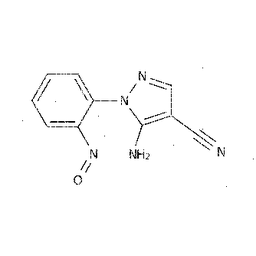

In [82]:
### PAD EXAMPLE

resize = 256
img_path = get_path_from_img_id(train_labels.sample(n=1).image_id.values[0])
img = Image.open(img_path)
img = pillow_pad(img, resize)
img

In [83]:
### Resize Training Samples (np.array)

resize = 256
resize_imgs(train_labels.image_id.values, TRAIN_DIR, resize=resize)

In [84]:
### Resize Test Samples (np.array)

resize = 256
resize_imgs(test_labels.image_id.values, TEST_DIR, resize=resize)

All resized images are stored in the same directory structure as original data, but the folders are renamed `train_resize` and `test_resize`

### Optical Character Recognition (OCR)

In [35]:
import pytesseract

In [55]:
img_path = get_path_from_img_id(train_labels.sample(n=1).image_id.values[0], TRAIN_RESIZE_DIR)
img = Image.open(img_path)
pytesseract.image_to_boxes(img)

'~ 0 0 0 0 0\n'

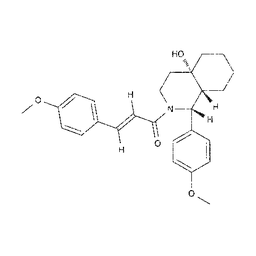

In [56]:
img

tesseract sucks

In [156]:
def convolve_kernel(window, kernel):
    kernel_size = kernel.shape[0]
    x_range = window.shape[0] - kernel.shape[0]
    y_range = window.shape[1] - kernel.shape[1]
    convolutions = []
    for x in range(x_range):
        for y in range(y_range):
            window_slice = window[x:x+kernel_size, y:y+kernel_size].copy()
            convolution = np.sum(window_slice@kernel)
            convolutions.append(convolution)
    score = np.max(convolutions)
    return score

In [262]:
def convolve_kernels(window, kernel_list):
    scores = []
    for kernel in kernel_list:
        scores.append(convolve_kernel(window, kernel))
    score = np.max(scores)
    return score

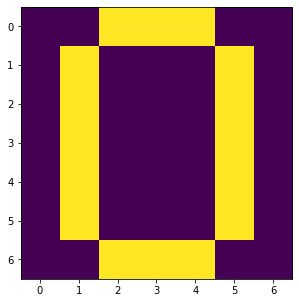

In [252]:
o_kernel = np.zeros((7, 7))
o_kernel[0,2:5] = [1,1,1]
o_kernel[1,1:6] = [1,0,0,0,1]
o_kernel[2,1] = 1
o_kernel[2,5] = 1
o_kernel[3,1] = 1
o_kernel[3,5] = 1
o_kernel[4,1] = 1
o_kernel[4,5] = 1
o_kernel[5,1:6] = [1,0,0,0,1]
o_kernel[6,2:5] = [1,1,1]
fig = plt.figure(figsize=(5,5))
plt.imshow(o_kernel)
plt.show()

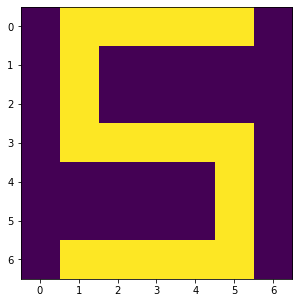

In [260]:
s_kernel = np.zeros((7, 7))
s_kernel[0,1:6] = [1,1,1,1,1]
s_kernel[1:4,1] = [1,1,1]
s_kernel[3,2:6] = [1,1,1,1]
s_kernel[4:6,5] = [1,1]
s_kernel[6,1:6] = [1,1,1,1,1]
fig = plt.figure(figsize=(5,5))
plt.imshow(s_kernel)
plt.show()

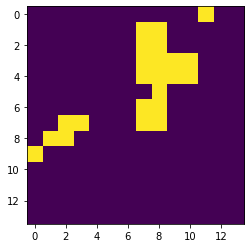

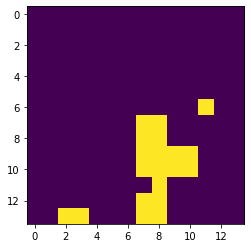

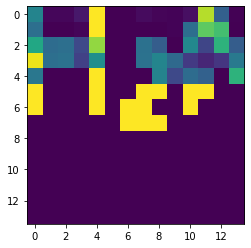

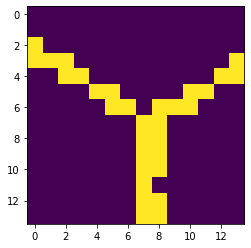

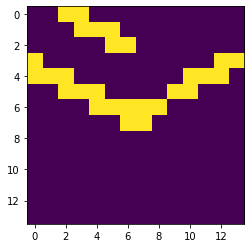

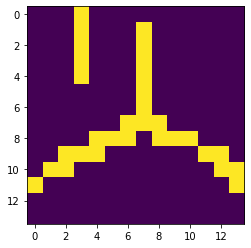

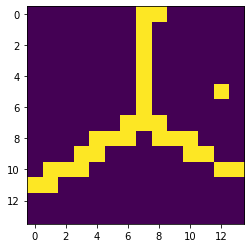

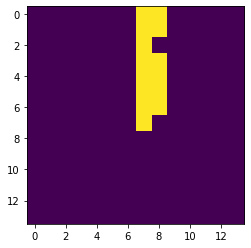

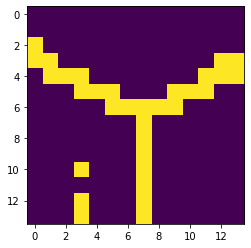

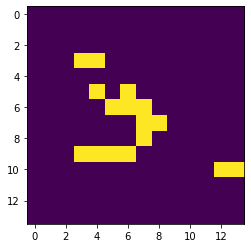

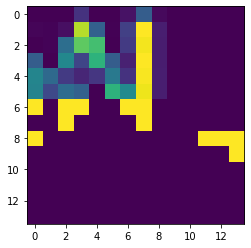

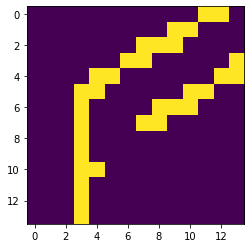

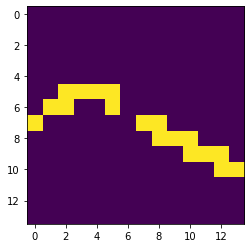

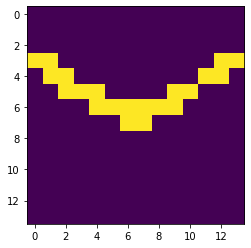

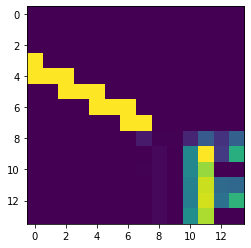

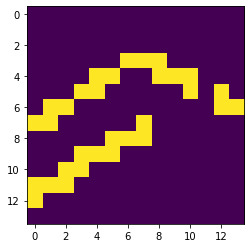

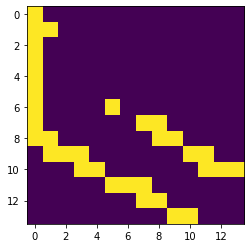

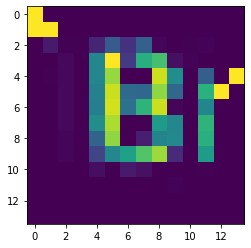

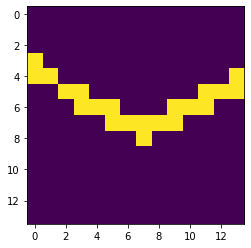

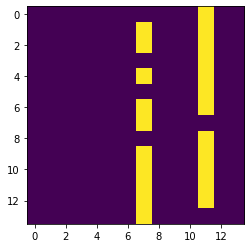

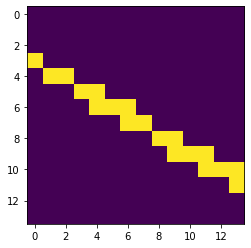

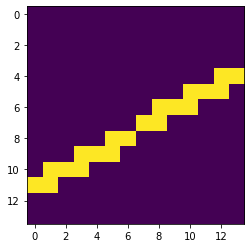

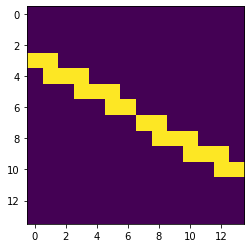

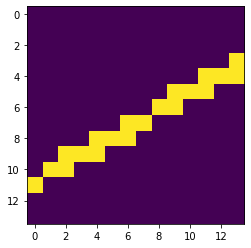

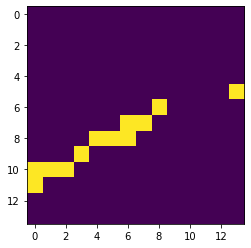

In [254]:
for window in window_list['imgs']:
    plt.imshow(window)
    plt.show()

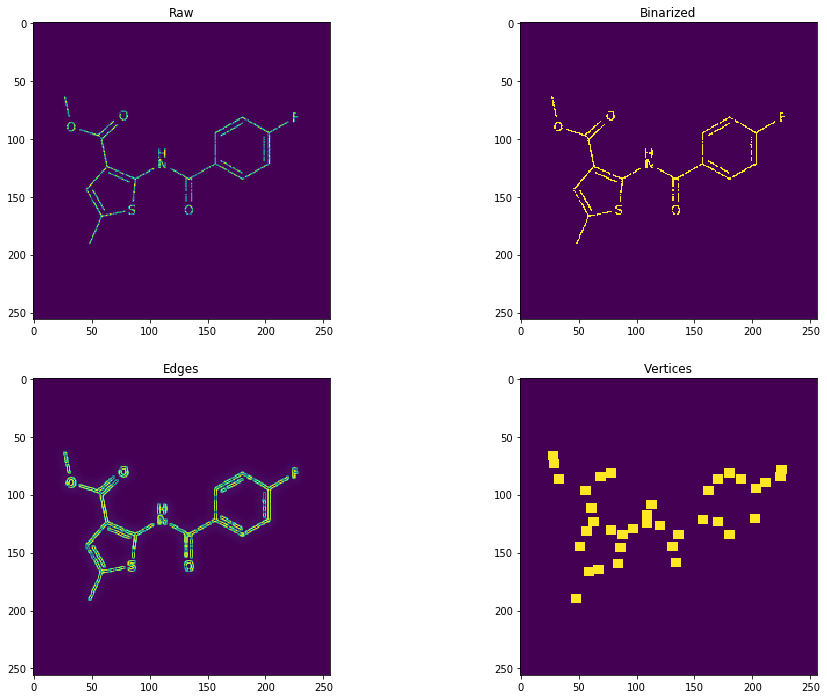

In [279]:
img_id = train_df.sample(n=1).image_id.values[0]
img_path = get_path_from_img_id(img_id, TRAIN_RESIZE_DIR)
img = Image.open(img_path)
img = img.convert('L')
# display(img)

img = np.array(img)
img = invert_and_normalize(img)

prebinarized = binarize(img)
edges = edge_enhance(prebinarized)
edges = edge_detect(edges)
vertex_map = get_vertices(img, window_size=4, window_mask=False, window_list=True)

fig, ax = plt.subplots(2, 2, figsize=(16,12))
ax[0,0].imshow(img)
ax[0,0].set_title('Raw')
ax[0,1].imshow(prebinarized)
ax[0,1].set_title('Binarized')
ax[1,0].imshow(edges)
ax[1,0].set_title('Edges')
ax[1,1].imshow(vertex_map)
ax[1,1].set_title('Vertices')
plt.show()

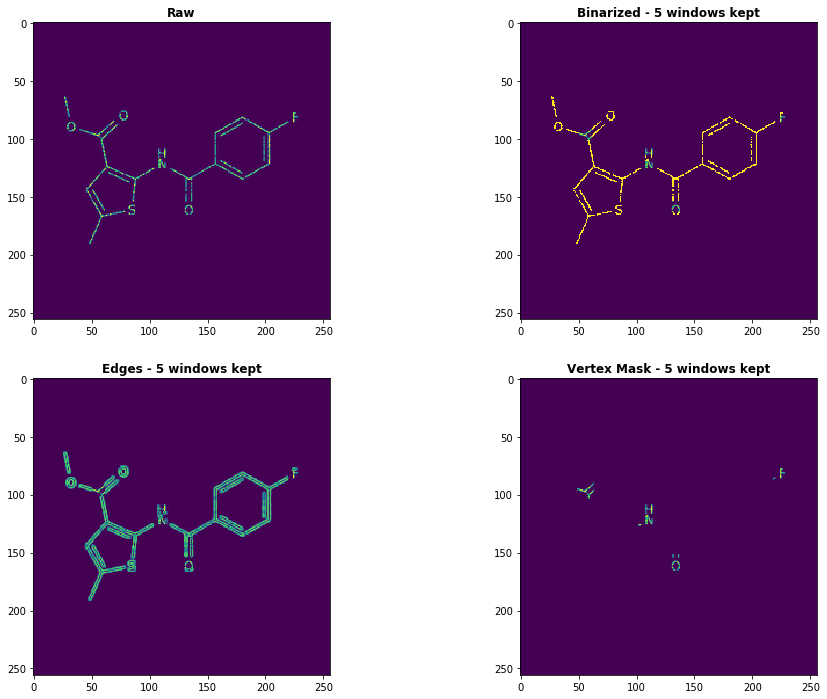

In [283]:
threshold = 45
kernel_list = [o_kernel, s_kernel]

vertex_windows, window_list = get_vertices(prebinarized, window_size=7, window_mask=True, window_list=True)
coords_list = window_list['coordinates']
img_list = window_list['imgs']
keep_idxs = []
for i, window in enumerate(img_list):
    score = convolve_kernels(window, kernel_list)
    if score > threshold:
        keep_idxs.append(i)
filtered_window_list = {'coordinates': [],
                        'imgs': []}
for idx in keep_idxs:
    filtered_window_list['coordinates'].append(coords_list[idx])
    filtered_window_list['imgs'].append(img_list[idx])

vertex_map, _ = get_vertex_map(filtered_window_list['coordinates'], img, window_size=7, window_list=False)
vertex_windows = np.where(vertex_map == 1, img, 0)

prebinarized = morph_around_windows(img, filtered_window_list, binarize)
edges = morph_around_windows(img, filtered_window_list, edge_enhance)
edges = morph_around_windows(edges, filtered_window_list, edge_detect)
fig, ax = plt.subplots(2, 2, figsize=(16,12))
ax[0,0].imshow(img)
ax[0,0].set_title('Raw', fontweight='bold')
ax[0,1].set_title('Binarized - {} windows kept'.format(len(keep_idxs)), fontweight='bold')
ax[0,1].imshow(prebinarized)
ax[1,0].set_title('Edges - {} windows kept'.format(len(keep_idxs)), fontweight='bold')
ax[1,0].imshow(edges)
ax[1,1].imshow(vertex_windows)
ax[1,1].set_title('Vertex Mask - {} windows kept'.format(len(keep_idxs)), fontweight='bold')
plt.show()

### PubChemPy Supplementation

In [7]:
import pubchempy as pcp

In [292]:
with open('../data/fg_names.json', 'r') as f:
    fg_names = json.load(f)

In [318]:
fg_names

{'secondary alcohol': 116826,
 'thioether': 166833,
 'aromatic compound': 2177379,
 'tertiary amine': 492485,
 'tertiary aliphatic/aromatic amine (alkylarylamine)': 193707,
 'aryl bromide': 174438,
 'carboxylic acid': 214091,
 'heterocyclic compound': 1845854,
 'carbonitrile': 123002,
 'alkene': 229069,
 'sulfonamide': 205474,
 'secondary amine': 381939,
 'secondary aliphatic amine (dialkylamine)': 249242,
 'secondary carboxylic acid amide': 142832,
 'aryl fluoride': 317152,
 'tertiary aliphatic amine (trialkylamine)': 329634,
 'ketone': 156308,
 'enol ether': 8742,
 'phenol or hydroxyhetarene': 143771,
 'alkyl aryl ether': 585158,
 'aryl chloride': 380530,
 'carboxylic acid amidine': 11591,
 'invalid molecule': 22117,
 'tertiary carboxylic acid amide': 416578,
 'imino(het)arene': 114838,
 'dialkyl ether': 305464,
 'secondary aliphatic/aromatic amine (alkylarylamine)': 106029,
 'carboxylic acid ester': 248090,
 'urea': 21156,
 'tertiary alcohol': 41625,
 'hydrazine derivative': 93483,


In [319]:
import operator
sorted_x = sorted(fg_names.items(), key=operator.itemgetter(1))

In [320]:
sorted_x

[('azide', 1),
 ('thiophosphoric acid', 1),
 ('isonitrile', 2),
 ('input structure contains query atom or query bond!', 2),
 ('quaternary ammonium salt', 3),
 ('thiocarbamic acid halide (halothioformic acid amide)', 4),
 ('carboxylic acid salt', 4),
 ('thiocarbonic acid ester halide (alkyl/aryl halothioformate', 4),
 ('hydroxy compound', 13),
 ('thiophosphoric acid halide', 15),
 ('thiosemicarbazone', 21),
 ('sulfenic acid', 27),
 ('carboxylic acid imide, N-unsubstituted', 27),
 ('nitrite', 28),
 ('sulfinic acid halide', 30),
 ('acyl bromide', 35),
 ('thiosemicarbazide', 53),
 ('acyl iodide', 56),
 ('sulfenic acid halide', 75),
 ('sulfinic acid ester', 79),
 ('sulfuric acid diester', 90),
 ('cyanate', 91),
 ('acyl fluoride', 97),
 ('carbonic acid ester halide (alkyl/aryl haloformate)', 102),
 ('enediol', 104),
 ('phosphoric acid halide', 111),
 ('acyl cyanide', 114),
 ('ether', 115),
 ('thiocarbonic acid monoester', 115),
 ('sulfenic acid ester', 119),
 ('semicarbazone', 128),
 ('carbo

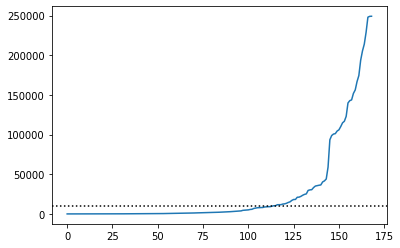

In [324]:
counts = fg_names.values()
counts = sorted(counts)[:-10]
plt.plot(counts)
plt.axhline(10000, ls=':', color='black')
plt.show()

In [323]:
50000 * 100

5000000

In [317]:
np.percentile(counts, 95)

306632.79999999993

In [47]:
for inchi in train_labels.InChI:
    c = pcp.get_compounds(inchi, 'inchi')
    print((c, inchi))

([Compound(82265033)], 'InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3')
([Compound(124916588)], 'InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-15-4-5-18(24)21(15,3)9-7-16(19)20/h13-16,19H,4-11H2,1-3H3/t13-,14+,15+,16-,19-,20+,21+/m1/s1')
([Compound(118087079)], 'InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-9-16-21(23(25)31)26-29(22(16)24(27)32)18-5-3-4-6-19(18)33-2/h3-8,13H,9-12H2,1-2H3,(H2,25,31)')
([Compound(120539154)], 'InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(16(22)23)8-4-2-3-5-9-17/h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21)(H,22,23)')
([Compound(104350096)], 'InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16/h8H,2-7H2,1H3,(H2,11,16)(H,12,14)')
([Compound(138826725)], 'InChI=1S/C19H22Br2N2O2/c1-13(2)10-16(19(24)25)23(9-8-14-6-4-3-5-7-14)15-11-17(20)22-18(21)12-15/h3-7,11-13,16H,8-10H2,1-2H3,(H,24,25)')
([Compound(133560351)], 'InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11

KeyboardInterrupt: 

In [55]:
test_inchi = 'InChI=1S/C24H43N5O2/c1-21(2)15-11-19(28-30)23(5,13-17(15)21)26-9-7-25-8-10-27-24(6)14-18-16(22(18,3)4)12-20(24)29-31/h15-18,25-27,30-31H,7-14H2,1-6H3/b28-19+,29-20+/t15-,16-,17+,18+,23+,24+/m1/s1'
c = pcp.get_compounds(test_inchi, 'inchi')[0]
c.record

{'id': {},
 'atoms': {'aid': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74],
  'element': [8,
   8,
   7,
   7,
   7,
   7,
   7,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]},
 'bond

In [57]:
pcp.download('PNG', 'test.png', test_inchi, 'inchi', overwrite=True)

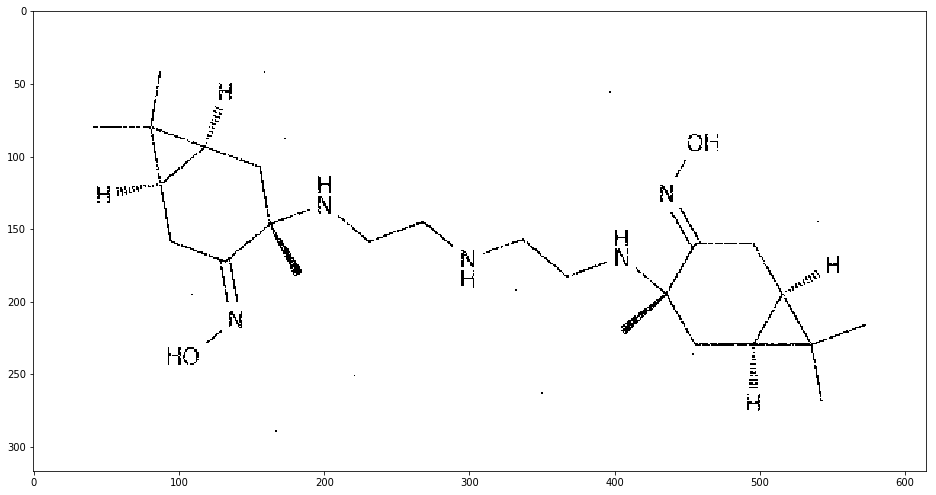

In [62]:
visualize_img_id(train_labels[train_labels.InChI == test_inchi].image_id.values[0])

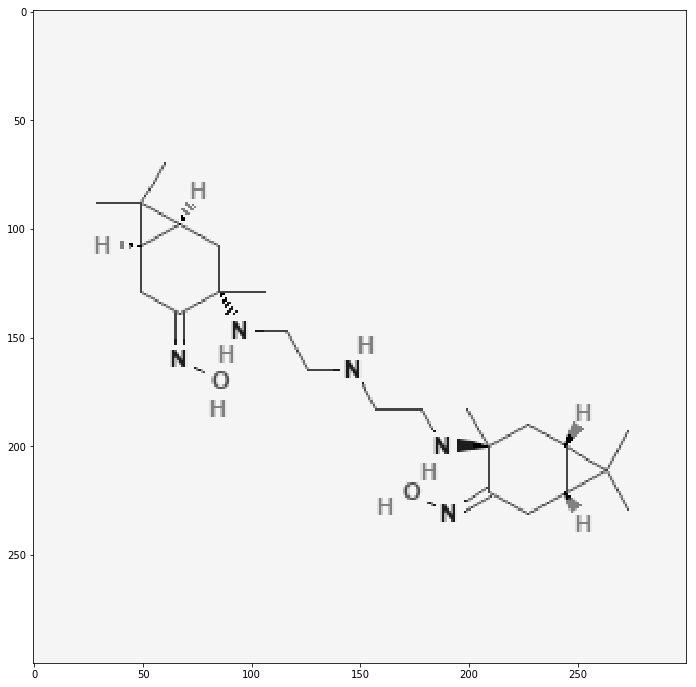

In [17]:
plt.figure(figsize=(16,12))
img = cv2.imread('test.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [15]:
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i,j] == 245:
            img[i,j] == 0

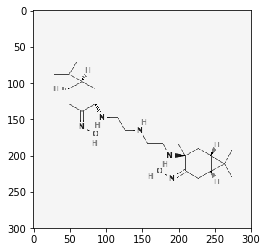

In [16]:
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [13]:
img

array([[245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       ...,
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245]], dtype=uint8)

### Calc Mean and StdDev of Dataset

In [162]:
def calc_data_mean_std(DIR):
    channel_1_means = []
    channel_2_means = []
    channel_3_means = []
    channel_1_stds = []
    channel_2_stds = []
    channel_3_stds = []
    for img_id in train_labels.sample(n=100).image_id.values:
        img_path = get_path_from_img_id(img_id, DIR)
        img = (255 - cv2.imread(img_path)) / 255
        means = np.mean(img.reshape(-1, img.shape[-1]), axis=0)
        stds = np.std(img.reshape(-1, img.shape[-1]), axis=0)
        channel_1_means.append(means[0])
        channel_2_means.append(means[1])
        channel_3_means.append(means[2])
        channel_1_stds.append(stds[0])
        channel_2_stds.append(stds[1])
        channel_3_stds.append(stds[2])
    channel_1_mean = np.mean(channel_1_means)
    channel_2_mean = np.mean(channel_2_means)
    channel_3_mean = np.mean(channel_3_means)
    channel_1_std = np.mean(channel_1_stds)
    channel_2_std = np.mean(channel_2_stds)
    channel_3_std = np.mean(channel_3_stds)
    means = [channel_1_mean, channel_2_mean, channel_3_mean]
    stds = [channel_1_std, channel_2_std, channel_3_std]
    mean_std_dict = {'means': means,
                     'stds': stds}
    with open(os.path.join(DIR, 'mean_std.json'), 'w') as f:
        json.dump(mean_std_dict, f)

In [ ]:
calc_data_mean_std(TRAIN_RESIZE_DIR)

# Data Loading

In [45]:
def inchi_tokenizer(substring):
    pattern =  "(\[[^\]]+]|Br?|Cl?|Si?|N|H|O|S|P|F|I|D|T|b|c|n|o|s|p|h|t|m|i|\(|\)|\.|=|#|-|,|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|1[0-9]|2[0-9]|[0-9])"
    regezz = re.compile(pattern)
    tokens = [token for token in regezz.findall(substring)]
    assert substring == ''.join(tokens), ("{} could not be joined -> {}".format(substring, tokens))
    return tokens

In [195]:
def encode_inchis(inchi, max_len, char_dict):
    "Converts tokenized InChIs to a list of token ids"
    for i in range(max_len - len(inchi)):
        inchi.append('<pad>')
    inchi_vec = [char_dict[c] for c in inchi]
    return inchi_vec

In [204]:
class MoleculeDataset(Dataset):
    """
    PyTorch Dataset class to load molecular images and InChIs
    """
    def __init__(self, labels_fn, source_dir, char_dict, max_inchi_len, transform=None):
        self.labels = pd.read_csv(labels_fn)
        self.source_dir = source_dir
        self.char_dict = char_dict
        self.max_inchi_len = max_inchi_len
        self.transform = transform
        with open(os.path.join(source_dir, 'mean_std.json'), 'r') as f:
            mean_std_dict = json.load(f)
        self.means = mean_std_dict['means']
        self.stds = mean_std_dict['stds']
    
    def __getitem__(self, i):
        ### grab image
        img_id = self.labels.image_id.values[i]
        img_path = get_path_from_img_id(img_id, self.source_dir)
        img = (255 - cv2.imread(img_path)) / 255
        if self.transform is not None:
            img = self.transform(img)
        img = torch.tensor(img)
        
        ### grab inchi
        inchi = self.labels.InChI.values[i]
        inchi = inchi.split('InChI=1S/')[1]
        inchi = ''.join(inchi)
        tokenized_inchi = substring_tokenizer(inchi)
        tokenized_inchi = ['<sos>'] + tokenized_inchi
        tokenized_inchi += ['<eos>']
        encoded_inchi = torch.tensor(encode_inchis(tokenized_inchi, self.max_inchi_len, self.char_dict))
        return img, encoded_inchi
        
        
    def __len__(self):
        return self.labels.shape[0]

In [24]:
mol_train = MoleculeDataset('../data/train.csv', TRAIN_RESIZE_DIR, CHAR_DICT, MAX_INCHI_LENGTH)

In [25]:
img, encoded_inchi = mol_train[0]

In [26]:
encoded_inchi

tensor([57, 38, 17, 42, 23, 44, 18, 45, 29,  5, 51,  7,  4, 12,  0, 32,  4, 33,
         4, 13,  4, 34,  4,  8,  4, 16,  0, 22,  1,  9,  4, 35,  4, 13,  1, 20,
         4, 17,  0, 23,  1, 19,  4, 10,  4, 14,  4, 30,  4, 18,  4, 29,  4, 31,
         4, 15,  0, 14,  1, 11,  4, 21,  5, 52, 18,  4, 31,  3, 34,  4,  9,  3,
        12,  3, 21,  4, 22, 42,  3, 32,  4, 33,  3, 10,  4, 11, 42, 18,  3,  7,
        42, 29,  3,  0, 42, 18,  3, 19,  3, 20,  3, 23,  1, 58, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 

# Building Model

In [32]:
mol_train = MoleculeDataset('../data/train.csv', TRAIN_RESIZE_DIR, CHAR_DICT, MAX_INCHI_LENGTH)

In [34]:
img, encoded_inchi = mol_train[0]
img.shape

torch.Size([5, 256, 256])

In [11]:
import skimage
print(skimage.__version__)

0.18.1


In [ ]:
img = img.view(1, img.shape[2], img.shape[0], img.shape[1]).float()

In [11]:
resnet26 = ResNet26()

In [12]:
get_model_parameters(resnet26)

10334952

In [ ]:
resnet26(img)

-- Input Shape --
torch.Size([1, 3, 256, 256])
-- Stemp Shape --
torch.Size([1, 64, 256, 256])
-- Layer1 Shape --
torch.Size([1, 256, 256, 256])
-- Layer2 Shape --
torch.Size([1, 512, 128, 128])
-- Layer3 Shape --
torch.Size([1, 1024, 64, 64])


In [287]:
axialnet = AxialAttention(64, 64)

# Exploring InChIs

In [157]:
substring_headers = {}
for i, inchi in enumerate(train_labels.InChI):
    inchi = inchi.split('/')[2:]
    for substring in inchi:
        substring_header = substring[0]
        if substring_header in substring_headers.keys():
            substring_headers[substring_header] += 1
        else:
            substring_headers[substring_header] = 1

In [158]:
substring_headers

{'c': 2424186,
 'h': 2424028,
 't': 399794,
 'm': 396177,
 's': 396150,
 'b': 152473,
 'i': 2645}

In [159]:
len(train_labels.InChI)

2424186

In [165]:
substring_headers['i'] / len(train_labels.InChI)

0.0010910878950707579

In [166]:
0.9 * 0.11

0.099

In [172]:
1000000 * 0.9 * 0.11111111111

99999.99999899999

In [288]:
n_samples = train_labels.shape[0]
n_train = int(n_samples * 0.8)
n_val = int(n_samples * 0.1)
n_test = n_samples - n_train - n_val
rand_idxs = np.random.choice(np.arange(train_labels.shape[0]), size=train_labels.shape[0], replace=False)
train_idxs = rand_idxs[:n_train]
val_idxs = rand_idxs[n_train:n_train+n_val]
test_idxs = rand_idxs[n_train+n_val:]
train_idxs.shape, val_idxs.shape, test_idxs.shape

((1939348,), (242418,), (242420,))

In [289]:
train_df = train_labels.iloc[train_idxs]
val_df = train_labels.iloc[val_idxs]
test_df = train_labels.iloc[test_idxs]

In [188]:
train_substring_headers = {}
for i, inchi in enumerate(train_df.InChI):
    inchi = inchi.split('/')[2:]
    for substring in inchi:
        substring_header = substring[0]
        if substring_header in train_substring_headers.keys():
            train_substring_headers[substring_header] += 1
        else:
            train_substring_headers[substring_header] = 1

for k, v in train_substring_headers.items():
    train_substring_headers[k] = v / train_df.shape[0]

In [189]:
test_substring_headers = {}
for i, inchi in enumerate(test_df.InChI):
    inchi = inchi.split('/')[2:]
    for substring in inchi:
        substring_header = substring[0]
        if substring_header in test_substring_headers.keys():
            test_substring_headers[substring_header] += 1
        else:
            test_substring_headers[substring_header] = 1

for k, v in test_substring_headers.items():
    test_substring_headers[k] = v / test_df.shape[0]

In [190]:
train_substring_headers

{'c': 1.0,
 'h': 0.999937206860311,
 't': 0.1649736200061693,
 'm': 0.16347895994393535,
 's': 0.163467042997717,
 'b': 0.0628114734524814,
 'i': 0.001085817138127032}

In [191]:
test_substring_headers

{'c': 1.0,
 'h': 0.9999133731266938,
 't': 0.1644260557134548,
 'm': 0.16295752395645555,
 's': 0.1629533988672505,
 'b': 0.0636625017015993,
 'i': 0.0011385246205949204}

In [290]:
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')

### Tokenizing

In [275]:
### Splitting into substrings

for inchi in train_df.InChI.values:
    og_inchi = inchi
    inchi = inchi.split('/')[1:]
    chemical_formula = inchi[0]
    atom_connection_layer = inchi[1]
    remaining_substrings = inchi[2:]

    hydrogen_layer = ''
    stereochemical_layer = ''
    isotopic_layer = ''
    for substring in remaining_substrings:
        if substring[0] == 'h' and len(hydrogen_layer) == 0:
            hydrogen_layer = '/' + substring
        elif substring[0] == 'i' or substring[0] == 'h' or (len(isotopic_layer) > 0 and (substring[0] == 'b' or substring[0] == 't' or substring[0] == 'm' or substring[0] == 's')):
            isotopic_layer += substring + '/'
        elif substring[0] == 'b' or substring[0] == 't' or substring[0] == 'm' or substring[0] == 's':
            stereochemical_layer += substring + '/'
    
#     print(og_inchi)
#     print('-- Chemical Formula --')
    chemical_formula_toks = substring_tokenizer(chemical_formula)
#     print('{} -> {}'.format(chemical_formula, chemical_formula_toks))
#     print('-- Atom Connection Sublayer --')
    atom_connection_toks = substring_tokenizer(atom_connection_layer)
#     print('{} -> {}'.format(atom_connection_layer, atom_connection_toks))
    if len(hydrogen_layer) > 0:
#         print('-- Hydrogen Sublayer --')
        hydrogen_toks = substring_tokenizer(hydrogen_layer)
#         print('{} -> {}'.format(hydrogen_layer, hydrogen_toks))
    if len(stereochemical_layer) > 0:
        stereochemical_layer = '/' + stereochemical_layer[:-1]
        stereochemical_toks = substring_tokenizer(stereochemical_layer)
#         print('-- Stereochemical Layer --')
#         print('{} -> {}'.format(stereochemical_layer, stereochemical_toks))
    if len(isotopic_layer) > 0:
#         print('-- Isotopic Layer --')
        isotopic_layer = '/' + isotopic_layer[:-1]
        isotopic_toks = substring_tokenizer(isotopic_layer)
#         print('{} -> {}'.format(isotopic_layer, isotopic_toks))
#     print('\n')
    recomp_inchi = 'InChI=1S/{}/{}{}{}{}'.format(chemical_formula, atom_connection_layer,
                                                 hydrogen_layer, stereochemical_layer, isotopic_layer)
    if recomp_inchi[-1] == '/':
        recomp_inchi = recomp_inchi[:-1]
    if og_inchi != recomp_inchi:
        print("{} -> og".format(og_inchi))
        print("{} -> recomp".format(recomp_inchi))
        print('\n')
        

In [10]:
### Tokenizing entire InChI

train_char_dict = {}
max_train_length = 0
for inchi in train_labels.InChI.values:
    og_inchi = inchi
    inchi = inchi.split('InChI=1S/')[1]
    inchi = ''.join(inchi)
    tokenized_inchi = tokenize_inchi(inchi)
    if len(tokenized_inchi) > max_train_length:
        max_train_length = len(tokenized_inchi)
    for tok in tokenized_inchi:
        if tok not in train_char_dict.keys():
            train_char_dict[tok] = 1
        else:
            train_char_dict[tok] += 1

In [11]:
test_char_dict = {}
max_test_length = 0
for inchi in test_labels.InChI.values:
    og_inchi = inchi
    inchi = inchi.split('InChI=1S/')[1]
    inchi = ''.join(inchi)
    tokenized_inchi = tokenize_inchi(inchi)
    if len(tokenized_inchi) > max_test_length:
        max_test_length = len(tokenized_inchi)
    for tok in tokenized_inchi:
        if tok not in test_char_dict.keys():
            test_char_dict[tok] = 1
        else:
            test_char_dict[tok] += 1

In [12]:
max_train_length, max_test_length

(346, 8)

In [13]:
train_char_dict

{'C': 2424179,
 '13': 3986369,
 'H': 10653784,
 '20': 2733517,
 'O': 2174980,
 'S': 782635,
 '/': 6195453,
 'c': 2424186,
 '1': 6244320,
 '-': 45779934,
 '9': 3978105,
 '(': 13530038,
 '2': 8450380,
 ')': 13530038,
 '8': 3937914,
 '15': 3834757,
 '6': 4046992,
 '5': 4353269,
 '10': 3887940,
 '3': 11535006,
 '7': 3928450,
 '12': 3987144,
 '11': 3946461,
 '4': 5325899,
 '14': 3942888,
 'h': 2424028,
 ',': 15921276,
 '21': 2444719,
 '0': 1149995,
 '22': 2181984,
 '25': 1637681,
 '17': 3492307,
 '23': 2007853,
 '19': 3005139,
 '18': 3270283,
 '24': 1831957,
 '16': 3691958,
 't': 399794,
 '+': 259353,
 'm': 396177,
 's': 396150,
 'N': 2242328,
 '28': 1098842,
 '27': 1265226,
 '26': 1453624,
 '29': 935851,
 'Br': 193476,
 'b': 152473,
 'F': 469886,
 'Cl': 420216,
 'P': 16547,
 'Si': 17642,
 'B': 6675,
 'I': 27208,
 'i': 2645,
 'D': 3978,
 'T': 197}

In [14]:
test_char_dict

{'H': 3232214,
 '2': 3232214,
 'O': 1616107,
 '/': 1616107,
 'h': 1616107,
 '1': 1616107}

In [15]:
len(train_char_dict.keys()), len(test_char_dict.keys()), len(set(list(train_char_dict.keys()) + list(test_char_dict.keys())))

(57, 6, 57)

In [85]:
labels = sorted(train_char_dict.keys())

In [86]:
def plot_char_freq(char_dict, labels, title='Train'):
    fig = plt.figure(figsize=(20,6))
    counts = []
    for label in labels:
        counts.append(char_dict[label])
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(labels)), labels)
    plt.title(title, fontweight='bold', fontsize=16)
    plt.show()

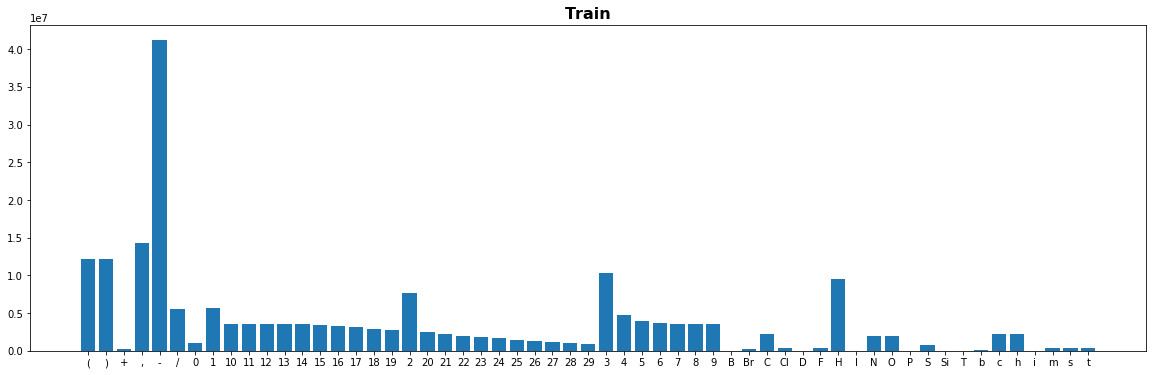

In [87]:
plot_char_freq(train_char_dict, labels)

In [297]:
desired_toks = ['+', '0', 'B', 'Br', 'D', 'Cl', 'F', 'I', 'P', 'S', 'Si', 'T', 'b', 'i', 'm', 's', 't']

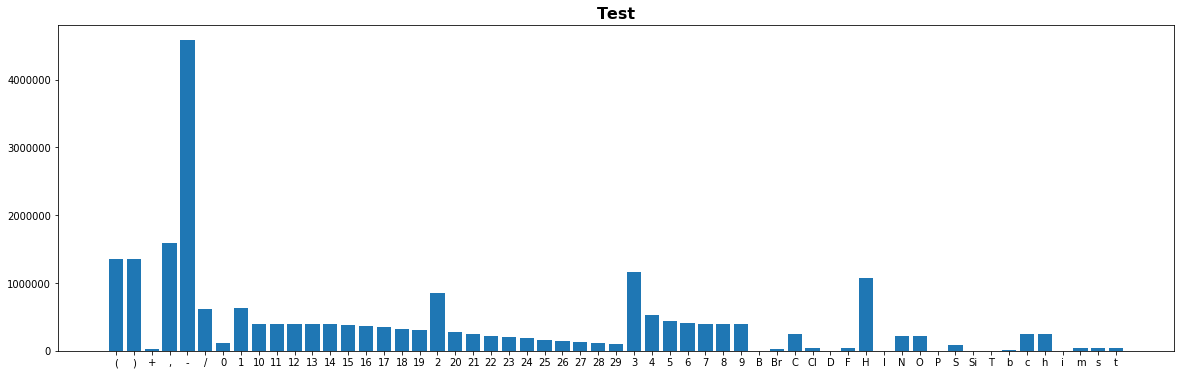

In [88]:
plot_char_freq(test_char_dict, labels, title='Test')

In [89]:
train_df.InChI.values[0]

'InChI=1S/C19H24N2O3/c1-14(6-7-15-8-10-18(23)11-9-15)21-19(24)20-12-16-4-2-3-5-17(16)13-22/h2-5,8-11,14,22-23H,6-7,12-13H2,1H3,(H2,20,21,24)'

In [171]:
char_dict = {}
ord_dict = {}
for i, label in enumerate(labels):
    char_dict[label] = i
    ord_dict[i] = label

n_toks = len(labels)
char_dict['<sos>'] = n_toks
char_dict['<eos>'] = n_toks + 1
char_dict['<pad>'] = n_toks + 2
ord_dict[n_toks] = '<sos>'
ord_dict[n_toks + 1] = '<eos>'
ord_dict[n_toks + 2] = '<pad>'

In [340]:
with open('char_dict.json', 'w') as f:
    json.dump(char_dict, f)
with open('ord_dict.json', 'w') as f:
    json.dump(ord_dict, f)

NameError: name 'char_dict' is not defined

In [344]:
CHAR_DICT

{'(': 0,
 ')': 1,
 '+': 2,
 ',': 3,
 '-': 4,
 '/': 5,
 '0': 6,
 '1': 7,
 '10': 8,
 '11': 9,
 '12': 10,
 '13': 11,
 '14': 12,
 '15': 13,
 '16': 14,
 '17': 15,
 '18': 16,
 '19': 17,
 '2': 18,
 '20': 19,
 '21': 20,
 '22': 21,
 '23': 22,
 '24': 23,
 '25': 24,
 '26': 25,
 '27': 26,
 '28': 27,
 '29': 28,
 '3': 29,
 '4': 30,
 '5': 31,
 '6': 32,
 '7': 33,
 '8': 34,
 '9': 35,
 'B': 36,
 'Br': 37,
 'C': 38,
 'Cl': 39,
 'D': 40,
 'F': 41,
 'H': 42,
 'I': 43,
 'N': 44,
 'O': 45,
 'P': 46,
 'S': 47,
 'Si': 48,
 'T': 49,
 'b': 50,
 'c': 51,
 'h': 52,
 'i': 53,
 'm': 54,
 's': 55,
 't': 56,
 '<sos>': 57,
 '<eos>': 58,
 '<pad>': 59}

In [173]:
ord_dict

{0: '(',
 1: ')',
 2: '+',
 3: ',',
 4: '-',
 5: '/',
 6: '0',
 7: '1',
 8: '10',
 9: '11',
 10: '12',
 11: '13',
 12: '14',
 13: '15',
 14: '16',
 15: '17',
 16: '18',
 17: '19',
 18: '2',
 19: '20',
 20: '21',
 21: '22',
 22: '23',
 23: '24',
 24: '25',
 25: '26',
 26: '27',
 27: '28',
 28: '29',
 29: '3',
 30: '4',
 31: '5',
 32: '6',
 33: '7',
 34: '8',
 35: '9',
 36: 'B',
 37: 'Br',
 38: 'C',
 39: 'Cl',
 40: 'D',
 41: 'F',
 42: 'H',
 43: 'I',
 44: 'N',
 45: 'O',
 46: 'P',
 47: 'S',
 48: 'Si',
 49: 'T',
 50: 'b',
 51: 'c',
 52: 'h',
 53: 'i',
 54: 'm',
 55: 's',
 56: 't',
 57: '<sos>',
 58: '<eos>',
 59: '<pad>'}

In [354]:
train_inchis = []
for inchi in train_df.InChI.values:
    train_inchis.append(['<sos>'] + tokenize_inchi(inchi) + ['<eos>'])
params = {'NUM_CHAR': len(CHAR_DICT.keys()),
          'MAX_LENGTH': MAX_INCHI_LENGTH,
          'CHAR_DICT': CHAR_DICT}

In [356]:
char_weights = get_char_weights(train_inchis, params)

In [358]:
char_weights[-1] = 0.2

In [360]:
np.save('../data/char_weights.npy', char_weights)

In [371]:
train_df.shape[0] / 256

7575.578125

In [372]:
256 / 16

16.0

In [19]:
def rotate_img(img, p=0.5):
    angles = [0, 90, 180, 270]
    angle = np.random.choice(angles, size=1, p=[1 - p, p / 3, p / 3, p / 3])[0]
    img = torch.tensor(img)
    if angle == 0:
        pass
    elif angle == 90:
        img = torch.rot90(img, 1, [1,2])
    elif angle == 180:
        img = torch.rot90(img, 1, [1,2])
        img = torch.rot90(img, 1, [1,2])
    elif angle == 270:
        img = torch.rot90(img, -1, [1,2])
    return img, angle

In [31]:
i = 6
test_img_id = train_df.image_id.values[i]
test_inchi = train_df.InChI.values[i]
img_path = get_path_from_img_id(test_img_id, TRAIN_RESIZE_DIR)
img = preprocess(img_path)
img = torch.tensor(img).unsqueeze(0)
img = F.interpolate(img, size=(128, 128))
img = img.squeeze(0)
img = img.numpy()

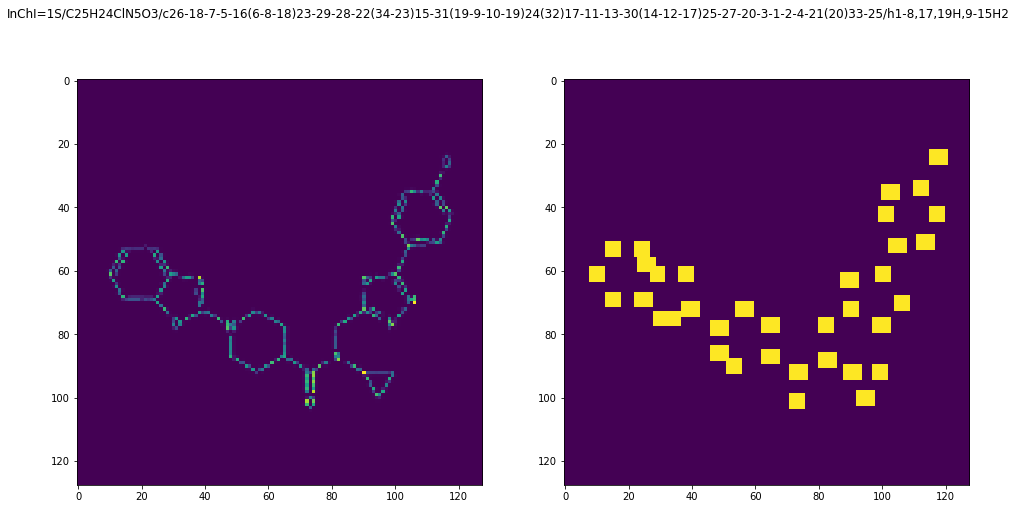

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(img[0,:,:])
ax[1].imshow(img[1,:,:])
plt.suptitle(test_inchi)
plt.show()

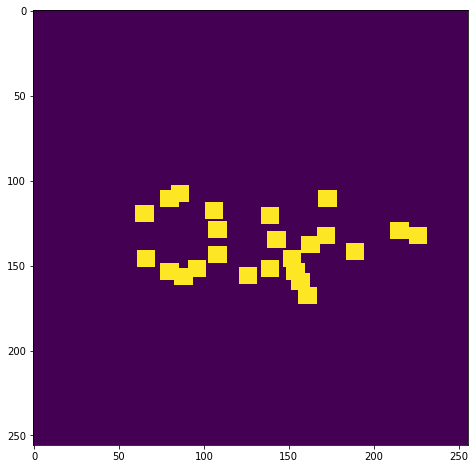

In [469]:
fig = plt.figure(figsize=(8,8))
plt.imshow(img[1,:,:])
plt.show()

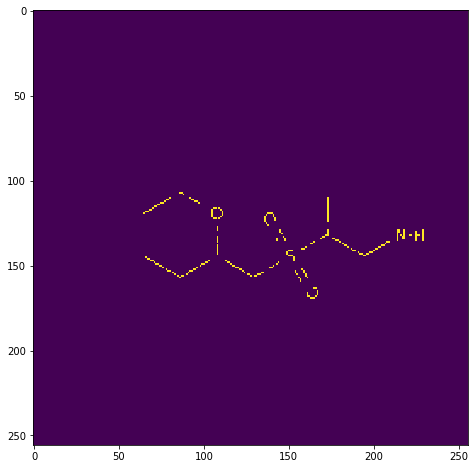

In [455]:
fig = plt.figure(figsize=(8,8))
plt.imshow(img[0,:,:])
plt.show()

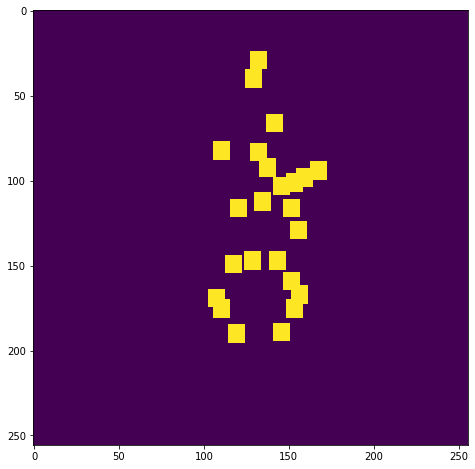

In [451]:
fig = plt.figure(figsize=(8,8))
plt.imshow(img[1,:,:])
plt.show()

In [409]:
test_img_id = train_df.image_id.values[0]
img_path = get_path_from_img_id(test_img_id, TRAIN_DIR)
img = Image.open(img_path)

img = np.array(img)

In [410]:
img.shape

(458, 574)

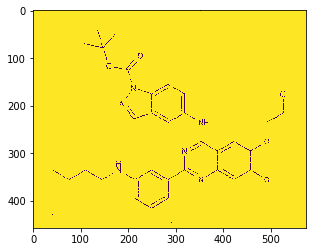

In [411]:
plt.imshow(img)
plt.show()

In [513]:
build_times = [10.309909014031291,20.02779781911522,40.275068615563214,80.98926744703203,163.3297253800556]
sizes = [0.028521257,0.080530632,0.161061264,0.322122528,0.64424508]
n_samples = [128,256,512,1024,2048]

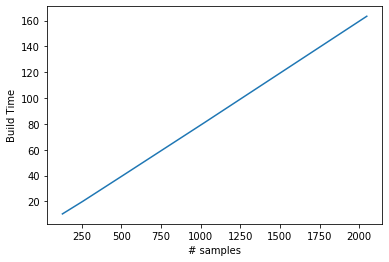

In [514]:
plt.plot(n_samples, build_times)
plt.xlabel('# samples')
plt.ylabel('Build Time')
plt.show()

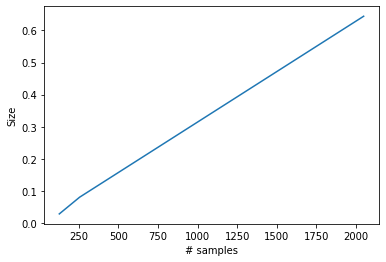

In [515]:
plt.plot(n_samples, sizes)
plt.xlabel('# samples')
plt.ylabel('Size')
plt.show()

In [549]:
gb_per_1K = 0.020098794 / 100 * 1000

In [517]:
n_sample = 200000 / 1000
gb = n_sample * gb_per_1K
gb

44.5644640625

In [518]:
train_df.shape[0] / 200000

9.69674

In [552]:
gb_per_1K * 200000 / 1000 + gb_per_1K * 200000 * (0.1) / 1000

44.2173468

In [523]:
test_labels.shape[0]

1616107

In [525]:
load_time = 0.30496428813785315
load_time * 200000 / 1000

60.99285762757063

In [556]:
test_imgs = np.load('test_imgs.npy')

NameError: name 'test_imgs' is not defined

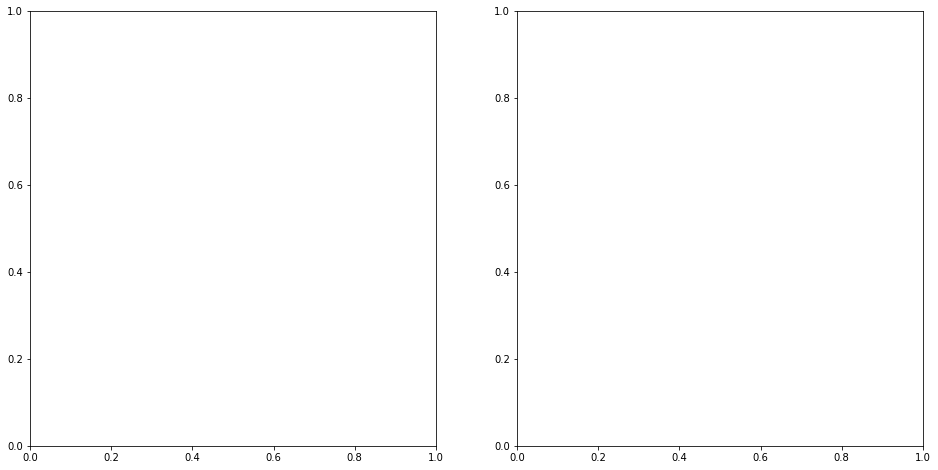

In [46]:
i = 191607
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(test_imgs[i,0,:,:])
ax[0].set_title('Img')
ax[1].imshow(test_imgs[i,1,:,:])
ax[1].set_title('Vertices')
plt.show()

In [39]:
train_df.shape[0] / 256 * 1.8 / 60 / 60 * 20

75.75578124999998

In [38]:
train_df.shape[0] / 256 * 8 / 60 / 60 * 5

84.17309027777777

In [553]:
train_df.InChI.values[0]

'InChI=1S/C33H37ClN6O4/c1-6-7-14-35-23-10-8-9-21(16-23)30-38-26-19-28(42-5)29(43-15-13-34)18-25(26)31(39-30)37-24-11-12-27-22(17-24)20-36-40(27)32(41)44-33(2,3)4/h8-12,16-20,35H,6-7,13-15H2,1-5H3,(H,37,38,39)'

In [554]:
17 / 256

0.06640625

In [555]:
80 / 200000

0.0004

In [45]:
80*10 / 60

13.333333333333334

In [43]:
200000 / 256

781.25

In [42]:
train_df.shape[0] / 781

2483.160051216389